<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_04_Joins_Sets_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Tables Together With Joins and Sets
### Brendan Shea, PhD

Welcome to Chapter 4. In this part of the book, we'll learn about joins and set operations using SQLite. We'll use a database called movies.sqlite, which is based on data from IMDB and includes movie, actor, director, person, and Oscar data.

- First, we'll show you the database schema for movies.sqlite. This is a guide to how the data is organized. We'll also display the first five rows of each table, so you can see what the data looks like.

- Next, we'll explain what an entity-relationship diagram is. It's a way of showing how different tables in a database are connected. It helps you understand the database's structure. We'll also discuss VARCHAR and CHAR, which are different kinds of data types, and explain how they compare to TEXT.

- Then, we'll talk about how tables relate to each other, using something called cardinalities. We'll go over "join" tables, like the Actor and Director ones, and explain their importance in connecting data. We'll also explain what primary keys are and why they're necessary in each table.


- The main part of this chapter is about joins: INNER JOIN, LEFT (OUTER) JOIN, and CROSS JOIN. We'll show you how each one works, give examples, and explain when you might want to use them.

- Finally, we'll go over set operations: UNION, DIFFERENCE, EXCEPT, and INTERSECT. These are methods you can use to combine or compare results from different SQL queries.

Remember, the key to understanding databases is practice. Don't be afraid to experiment and make mistakes. That's how you'll learn. Now, let's get started on joins and set operations!


## Introduction to the Movie Database
For this chapter, we'll be using a database based on data from the Internet Movie Database (IMDB). The full dataset is available here: https://developer.imdb.com/non-commercial-datasets/. The formatting of this datbase is adapted from that of David Sullivan (a computer science professor at Harvard/Boston U). We'll just be using a small part of this data, based on movies that have (at one point or another) been in the "top 100" in terms of box office returns.

To start off with, we need to download a copy of the database and connect to it:

In [1]:
!pip install SQLAlchemy==1.3.24 -q # Downgrade to avoid problems with more recent version

# Now let's download the file we'll be using for this lab
!wget -N 'https://github.com/brendanpshea/database_sql/raw/main/data/movie.sqlite' -q

%load_ext sql
%sql sqlite:///movie.sqlite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 56.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Exploring the Data
Now, we can take a look at the data to see what tables, attributes, and relationships are present. First, we'll display the table "schema" (the list of tables:

In [ ]:
# Now let's diplay the table schema
%sql SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///movie.sqlite
Done.


name
Movie
Person
Actor
Director
Oscar


In [2]:
# Show the data types for each table
movie_df = %sql PRAGMA table_info(Movie);
person_df = %sql PRAGMA table_info(Person);
actor_df = %sql PRAGMA table_info(Actor);
director_df = %sql PRAGMA table_info(Director);
oscar_df = %sql PRAGMA table_info(Oscar);

print('\nMovie\n', movie_df,'\nPerson\n',person_df, '\nActor\n', actor_df,
      '\nDirector\n', director_df, '\nOscar\n', oscar_df)

 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.

Movie
 +-----+---------------+-------------+---------+------------+----+
| cid |      name     |     type    | notnull | dflt_value | pk |
+-----+---------------+-------------+---------+------------+----+
|  0  |       id      |   CHAR(7)   |    0    |    None    | 1  |
|  1  |      name     | VARCHAR(64) |    0    |    None    | 0  |
|  2  |      year     |   INTEGER   |    0    |    None    | 0  |
|  3  |     rating    |  VARCHAR(5) |    0    |    None    | 0  |
|  4  |    runtime    |   INTEGER   |    0    |    None    | 0  |
|  5  |     genre     | VARCHAR(16) |    0    |    None    | 0  |
|  6  | earnings_rank |   INTEGER   |    0    |    None    | 0  |
+-----+---------------+-------------+---------+------------+----+ 
Person
 +-----+------+--------------+---------+------------+----+
| cid | name |     type     | notnull |

Now, using our knowledge of the table names, we can display the first few rows of each table. (Note: I've used a bit of "Python" here to format things a bit more nicely):

In [ ]:
# Show the first 5 rows of each table
movie_df = %sql SELECT * FROM Movie LIMIT 5;
person_df = %sql SELECT * FROM Person LIMIT 5;
actor_df = %sql SELECT * FROM Actor LIMIT 5;
director_df = %sql SELECT * FROM Director LIMIT 5;
oscar_df = %sql SELECT * FROM Oscar LIMIT 5;
print('\nMovie\n', movie_df,'\nPerson\n',person_df, '\nActor\n', actor_df,
      '\nDirector\n', director_df, '\nOscar\n', oscar_df)

 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.
 * sqlite:///movie.sqlite
Done.

Movie
 +---------+------------------------------+------+--------+---------+-------+---------------+
|    id   |             name             | year | rating | runtime | genre | earnings_rank |
+---------+------------------------------+------+--------+---------+-------+---------------+
| 2488496 | Star Wars: The Force Awakens | 2015 | PG-13  |   138   |   A   |       1       |
| 4154796 |      Avengers: Endgame       | 2019 | PG-13  |   181   |  AVS  |       2       |
| 1087260 |   Spider-Man: No Way Home    | 2021 | PG-13  |   148   |  AVFS |       3       |
| 0499549 |            Avatar            | 2009 | PG-13  |   162   |  AVYS |       4       |
| 1745960 |      Top Gun: Maverick       | 2022 | PG-13  |   130   |   AD  |       5       |
+---------+------------------------------+------+--------+---------+-------+------------

### Movies: Basic Structure

Our database consists of five tables: Movie, Person, Actor, Director, and Oscar. These tables store data related to movies, persons (actors and directors), and Oscar awards. Now, let's explore each of these tables, their attributes, data types, and primary keys.

### Data Types

As we've discussed previously, every column in a SQL table has a related "data type". The data type defines what kind of data a column can store. Here are some of the data types found in our tables:

1.  **CHAR:** This type is used to store character strings of a fixed length. The number within the parentheses (like CHAR(7)) represents the fixed length of characters the field can hold. (This is a more specific version of SQLite's `TEXT` type).

2.  **VARCHAR:** Unlike CHAR, VARCHAR is used for variable-length strings. The number within the parentheses represents the maximum number of characters the field can hold. (This is a more specific version of SQLite's `TEXT` type).

3.  **INTEGER:** This type is used for integer values.

4.  **DATE:** This type is used to store date values. In SQLite, these are stored as a type of TEXT.

### Tables


1\. Movie: This table contains information about different movies. It has 7 attributes:

-   `id` (CHAR(7)): This is a unique identifier for each movie. This serves as the primary key for this table.
-   `name` (VARCHAR(64)): The name of the movie.
-   `year` (INTEGER): The year when the movie was released.
-   `rating` (VARCHAR(5)): The MPAA rating of the movie.
-   `runtime` (INTEGER): The duration of the movie in minutes.
-   `genre` (VARCHAR(16)): The genre of the movie.
-   `earnings_rank` (INTEGER): The earnings rank of the movie.

2\. Person: This table stores data related to persons (actors and directors). It consists of 4 attributes:

-  `id` (CHAR(7)): This is a unique identifier for each person. This is the primary key for this table.
-   `name` (VARCHAR(64)): The name of the person.
-   `dob` (DATE): The date of birth of the person.
-   `pob` (VARCHAR(128)): The place of birth of the person.

3\. Actor and Director: These are "join tables" which store the relationship between movies and persons (actors or directors). A join table is used to resolve many-to-many relationships by breaking it down into two one-to-many relationships. In this case, a movie can have multiple actors and a person can act in multiple movies. Same applies for directors. Each of these tables has two attributes:

-   `actor_id/director_id` (CHAR(7)): This refers to the id of the person who is an actor/director. This forms part of the composite primary key.
-   `movie_id` (CHAR(7)): This refers to the id of the movie. This also forms part of the composite primary key.

4\. Oscar: This table stores information about Oscar awards. It contains 4 attributes:

-   `movie_id` (CHAR(7)): This refers to the id of the movie that won an Oscar.
-   `person_id` (CHAR(7)): This refers to the id of the person who won an Oscar.
-   `type` (VARCHAR(23)): This represents the type of Oscar award.
-   `year` (INTEGER): The year when the Oscar was awarded.

The key for this table is a combination of ALL FOUR columns.

### Movies: Some Design Principles
Let's conclude with some key takeaways:

-   Use of Primary Keys: Unique identifiers (primary keys) ensure that each record in a table is unique. They also allow us to link tables together efficiently. The Movie and Person tables demonstrate this.

-   Importance of Join Tables: The Actor and Director tables illustrate how join tables enable many-to-many relationships between entities. Many actors can star in many movies, and a movie can have multiple directors.

-   Composite Primary Keys: The Actor, Director, and Oscar tables show how composite primary keys (where more than one column is used to identify a record uniquely) can handle complex relationships.

-   Real-world Entity Representation: The design of the Oscar table emphasizes that database design should closely reflect the realities of the data you're working with. It demonstrates how to incorporate multiple, overlapping relationships in a single table.

This dataset is an example of a relational database, where tables connect via relationships, allowing us to organize complex, real-world data in a structured way. In the next sections, we'll explore how to leverage these relationships to query and manipulate our data efficiently. Remember, practice is the key to mastering database design, so don't be afraid to experiment and learn from your mistakes!

## An Entity-Relationship Diagram of the Movie Data
To help us better understand the stucture of the movie data, let's create an **entity-relationship** diagram.

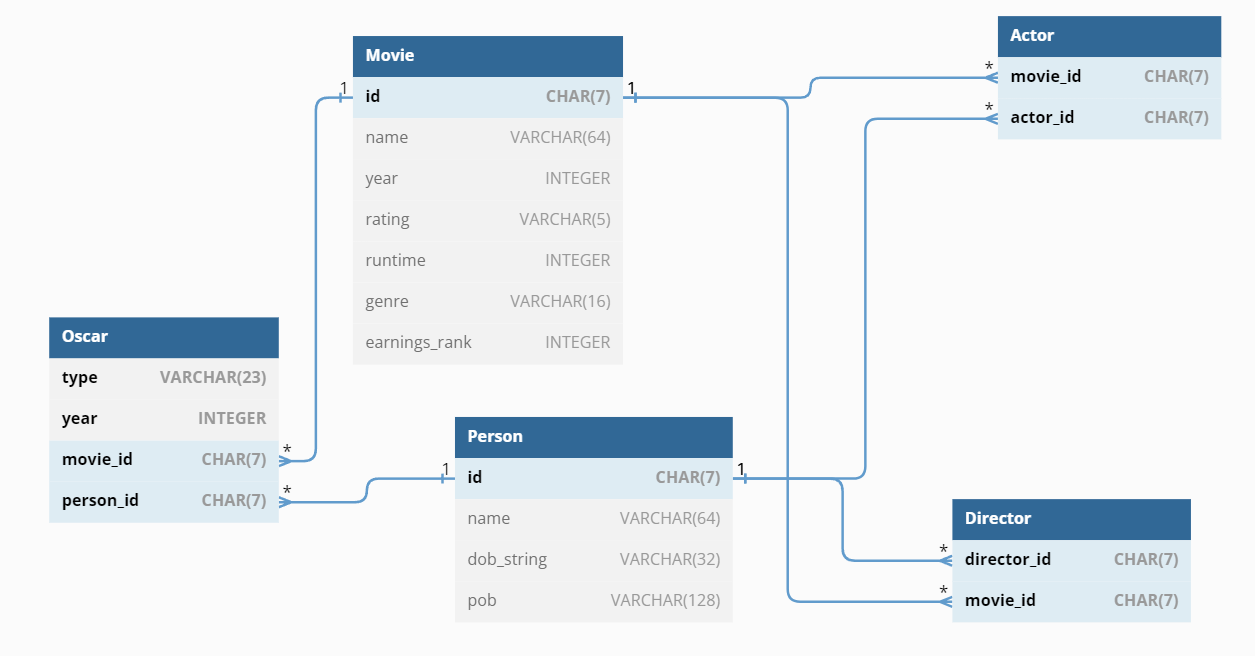

In [ ]:
import requests
from IPython.display import Image

url = "https://github.com/brendanpshea/database_sql/raw/main/images/movies_crows_foot.png"

response = requests.get(url)

if response.status_code == 200:
  image = Image(response.content)
  display(image)

### Why ER Diagrams?
An **Entity-Relationship (ER) diagram** (like the one you see here) is a visual tool that allows us to model and represent the relationships between different entities in a database. An 'entity' could be anything we want to store information about, such as movies, people, or awards in our movies.sqlite database.

In an ER diagram, **entities** (roughly, classes of things corresponding to tables) are usually represented as rectangles, while **relationships** are shown as lines or arrows connecting these rectangles. These relationships illustrate how data in one entity relates to data in another. For example, in our movies.sqlite database, a relationship exists between the 'Movie' and 'Person' entities through the 'Actor' and 'Director' entities.

This diagram used a simplified version of **Crow's foot notation**, which is a type of ER diagram where relationships are displayed with symbols that somewhat resemble a bird's footprints (hence the name). This notation is particularly helpful in showing the cardinality of relationships, or in other words, how many instances of one entity relate to instances of another entity.

In crow's foot notation, we look at the **connectors** at the end of lines to determine the relationships between entities.

-   A `1` (also indicated with `|`) stands for 'exactly 1'.
-   A crow's foot (`<` or `>`) symbol stands for 'many'.
-  A circle (`O`) on a line represents "optional" (we don't have any of these in this diagram).

So, for example, consider the line between 'Movie' and 'Director'. Since there is a crow's foot ("many") next to the Director box and a 1 next to the Movie box, this means there is a **many-to-one** relationship between directors and movies: Every director can direct many movies, but each movie (at least for the purposes of this database can have only one director). Many-to-one relationships form the "heart" of relational databases, since **one-to-one relationships** are often encoded as "attributes" of tables (for example, a Person's relationships with their own name) while **many-to-many** relationships (for example, the relationship between Persons and Movies--a person can be in many movies and a movie can have many persons) can't be represented without breaking them down into multiple many-to-one (or one-to-many) tables (as we've done here with Director and Actor).

### The Role of ER Diagrams in Database Design and Interpretation

ER diagrams play a crucial role in both the design and interpretation of databases:

-   Design: When designing a database, ER diagrams help us to visualize the structure and relationships in our database before we start creating it. By mapping out entities and their relationships, we can see and adjust our database's design more easily. It helps ensure we accurately represent the data and relationships we want to capture.

-   Interpretation: ER diagrams can also be handy tools for understanding existing databases. They provide a clear, visual representation of the structure of a database, making it easier to understand the relationships between different entities. This understanding is key when it comes to effectively querying a database.

Remember, a well-designed ER diagram can save you time and trouble. It gives you a clear roadmap of your database, helps prevent errors, and makes the database easier to work with, whether you're the one who created it or not.

## SQL JOINS

SQL Joins allow us to combine rows from two or more tables based on a related column between them. This is where the relationships we've been talking about really come into play. The first type of join we'll discuss is the INNER JOIN.

### INNER JOIN

An INNER JOIN returns records that have matching values in both tables being joined. This is the most common form of join in SQL, and is sometimes called a **natural join** (or just a JOIN -- you don't need to include INNER).

The general form of an SQL JOIN statement looks like this:

```
SELECT column1, column2, ...
FROM table1
[INNER] JOIN table2 ON condition;
```

The INNER JOIN keyword selects records that have matching values in both tables. This means you only get rows back when there's something to match in both tables.

To illustrate, consider two simplified tables in our database, 'Actor' and 'Person'. The 'Actor' table contains two columns: 'actor_id' and 'movie_id'. The 'Person' table includes 'id' and 'name'. Here are the tables with a few rows of data:

'Actor' Table:

| actor_id | movie_id |
| --- | --- |
| 1 | 100 |
| 2 | 100 |
| 3 | 101 |
| 4 | 102 |

'Person' Table:

| id | name |
| --- | --- |
| 1 | Tom Hanks |
| 2 | Morgan Freeman |
| 3 | Meryl Streep |
| 5 | Robert De Niro |

Now, suppose we want to find out which actors played in the movie with the ID '100'. To do that, we can use an INNER JOIN to combine the 'Actor' and 'Person' tables:

```
SELECT Person.name
FROM Actor
JOIN Person ON Actor.actor_id = Person.id
WHERE Actor.movie_id = 100;`
```

This statement takes the 'Actor' table and joins it with the 'Person' table where the 'actor_id' in 'Actor' matches the 'id' in 'Person'. We're only interested in the movie with ID '100', so we specify that with `WHERE Actor.movie_id = 100`.

The result of this query would look like this:

| name |
| --- |
| Tom Hanks |
| Morgan Freeman |

This result shows us that Tom Hanks and Morgan Freeman were both actors in the movie with the ID '100'.

Now, let's move onto multiple-table joins. Suppose we want to get a list of movie names along with the actors. To do this, we would join three tables: 'Movie', 'Actor', and 'Person'. Let's start by adding a 'Movie' table into our example:

'Movie' Table:

| id | name |
| --- | --- |
| 100 | Forrest Gump |
| 101 | The Godfather |
| 102 | Casablanca |

We could adjust our previous SQL query to include the 'Movie' table like this:

```
SELECT Movie.name, Person.name
FROM Movie
JOIN Actor ON Movie.id = Actor.movie_id
JOIN Person ON Actor.actor_id = Person.id;
```

Now we are joining 'Movie' to 'Actor', and then that result to 'Person'. This would give us a list of movie names along with the corresponding actor names, something like this:

| Movie Name | Actor Name |
| --- | --- |
| Forrest Gump | Tom Hanks |
| Forrest Gump | Morgan Freeman |
| The Godfather | Meryl Streep |

### LEFT JOIN (LEFT OUTER JOIN)

The general form of a LEFT [OUTER] JOIN SQL statement looks like this:

```
SELECT column1, column2, ...
FROM table1
LEFT JOIN table2 ON condition;
```

A LEFT JOIN returns all records from the left table (table1), and the matched records from the right table (table2). If there is no match, the result is NULL on the right side. This is quite different from an INNER JOIN, which only returns records where there is a match in both tables.

Let's go back to our example with the 'Actor' and 'Person' tables. If we wanted a list of all actors, whether or not they were in a movie, we could use a LEFT JOIN.

```
SELECT Person.name
FROM Person
LEFT JOIN Actor ON Person.id = Actor.actor_id;
```

In this case, the result would include all persons, regardless of whether they are associated with a movie in the 'Actor' table. If a person isn't an actor in any movie (i.e., there's no matching actor_id in the 'Actor' table), we'd see NULL for that person's movie.

Consider our previous 'Person' table and assume that these are all the people in our database, but only some of them are actors:

'Person' Table:

| id | name |
| --- | --- |
| 1 | Tom Hanks |
| 2 | Morgan Freeman |
| 3 | Meryl Streep |
| 5 | Robert De Niro |

The result of our LEFT JOIN query would look like this:

| name | movie_id |
| --- | --- |
| Tom Hanks | 100 |
| Morgan Freeman | 100 |
| Meryl Streep | 101 |
| Robert De Niro | NULL |

As you can see, we have every person in our result, but Robert De Niro's movie_id is NULL because he does not appear in the 'Actor' table.

In contrast, if we had used an INNER JOIN instead, Robert De Niro wouldn't appear in our result at all, because INNER JOIN only includes records where there's a match in both tables. The choice between INNER JOIN and LEFT JOIN depends on whether you want to include all records from one table (LEFT JOIN), or only records where there's a match in both tables (INNER JOIN).

Some versions of SQL also ofter commands for RIGHT (OUTER) JOIN (which just reverses the order of the two tables in LEFT JOIN) and FULL OUTER JOIN (which combines the results of LEFT and RIGHT joins). However, you can replicate these by smartly using LEFT JOIN.

### CROSS JOIN

The general form of a CROSS JOIN SQL statement looks like this:

```
SELECT column1, column2, ...
FROM table1
CROSS JOIN table2;
```

A CROSS JOIN returns the Cartesian product of rows from both tables. Essentially, it combines every row of the first table with every row of the second table. If the first table has 'n' rows and the second table has 'm' rows, the result will be a table with n*m rows.

The CROSS JOIN is a key theoretical concept, as it represents the maximum possible combination of rows between two tables. Other types of joins can be viewed as a filtered version of the CROSS JOIN where only the relevant rows are returned based on the specified condition.

Let's illustrate this with a small example. Suppose we have the following 'Actor' and 'Movie' tables:

'Actor' Table:

| actor_id | name |
| --- | --- |
| 1 | Tom Hanks |
| 2 | Morgan Freeman |

'Movie' Table:

| id | name |
| --- | --- |
| 100 | Forrest Gump |
| 101 | The Godfather |

If we were to apply a CROSS JOIN to these two tables:

```
SELECT Actor.name, Movie.name
FROM Actor
CROSS JOIN Movie;
```

The result would be:

| Actor Name | Movie Name |
| --- | --- |
| Tom Hanks | Forrest Gump |
| Tom Hanks | The Godfather |
| Morgan Freeman | Forrest Gump |
| Morgan Freeman | The Godfather |

As you can see, every actor is paired with every movie, regardless of whether they actually have any connection. This result might seem nonsensical in real-world applications, and that's why the CROSS JOIN is not used as often as the other types of joins in practical data analysis tasks.

However, understanding the CROSS JOIN is valuable, because it serves as a baseline for understanding the more commonly used types of joins. For INNER JOIN, LEFT JOIN, and others, you can think of starting with the CROSS JOIN's complete set of combinations and then eliminating the rows that don't meet the specific conditions of the join. The CROSS JOIN provides the complete 'universe' of potential combinations from which these other, more selective joins draw their results.

## Set Opeations in SQL
SQL also allows us to do basic **set** operations, of the sort you might have learned about in high-school or college math classes. In SQL, the main set operations we talk about are UNION, INTERSECT, and EXCEPT. All these operations can be applied to the result sets returned by SELECT statements.

To help see how these work, let's suppose we have the following tables:

#### Old_Movies:

| id | title |
| --- | --- |
| 1 | Avatar |
| 2 | Titanic |
| 3 | The Godfather |
| 4 | Star Wars |
| 5 | Jaws |

#### New_Movies:

| id | title |
| --- | --- |
| 1 | Avatar |
| 2 | Endgame |
| 3 | Inception |
| 4 | Interstellar |
| 5 | Titanic |

### UNION

The `UNION` operator is used to combine the result sets of 2 or more SELECT statements. However, it removes duplicate rows from the result set. Also, the SELECT statements within the UNION must have the same number of columns and the corresponding columns must have compatible data types. For example:


```
SELECT title FROM Old_Movies
UNION
SELECT title FROM New_Movies;
```

This gives us:

| title |
| --- |
| Avatar |
| Titanic |
| The Godfather |
| Star Wars |
| Jaws |
| Endgame |
| Inception |
| Interstellar |


### INTERSECT

The INTERSECT operator returns the intersection of 2 or more SELECT statements, i.e., it returns only the rows that are common to all the SELECT statements. For example:

```
SELECT title FROM Old_Movies
INTERSECT
SELECT title FROM New_Movies;
```

This gives us:

| title |
| --- |
| Avatar |
| Titanic |

### EXCEPT

The EXCEPT operator returns the difference between the first SELECT statement and the second SELECT statement. It returns rows from the first SELECT statement that are not returned by the second SELECT statement. For example:


```
SELECT title FROM Old_Movies
EXCEPT
SELECT title FROM New_Movies;
```

This gives us:

| title |
| --- |
| The Godfather |
| Star Wars |
| Jaws |

These set operations help you manipulate and analyze your data in a variety of ways, providing you with the flexibility to obtain the insights you need. Just like SQL join operations, they're another powerful tool in your SQL toolkit for data analysis and manipulation.

## Sample Queries
Let's try out what we've learned using joins to explore our movies database. Along the way, we'll also learn a few new tricks and techniques in SQL


### Example 1: Actors from Batman Begins

In [ ]:
%%sql
-- Get a list of actors in "Batman Returns"
SELECT * FROM Person
JOIN Actor ON Person.id = Actor.actor_id
JOIN Movie on Movie.id = Actor.movie_id
WHERE Movie.name = "Batman Returns";

 * sqlite:///movie.sqlite
Done.


id,name,dob,pob,actor_id,movie_id,id_1,name_1,year,rating,runtime,genre,earnings_rank
0000474,Michael Keaton,1951-09-05,"Coraopolis, Pennsylvania, USA",0000474,0103776,0103776,Batman Returns,1992,PG-13,126,AYRT,None
0000362,Danny DeVito,1944-11-17,"Neptune, New Jersey, USA",0000362,0103776,0103776,Batman Returns,1992,PG-13,126,AYRT,None
0000201,Michelle Pfeiffer,1958-04-29,"Santa Ana, California, USA",0000201,0103776,0103776,Batman Returns,1992,PG-13,126,AYRT,None
0000686,Christopher Walken,1943-03-31,"Queens, New York, USA",0000686,0103776,0103776,Batman Returns,1992,PG-13,126,AYRT,None
0001284,Michael Gough,1917-11-23,Malaya. [now Malaysia],0001284,0103776,0103776,Batman Returns,1992,PG-13,126,AYRT,None


Here, we "join" Actor, Person, and Movie to get a list of actors in "Batman Returns" by doing the following:

-   `SELECT *` - Select all columns from the `Person` table.
-   `FROM Person` - Specify that the data should be retrieved from the `Person` table.
-   `JOIN Actor ON Person.id = Actor.actor_id` - Join the `Person` table to the `Actor` table on the `Person.id` and `Actor.actor_id` columns.
-   `JOIN Movie on Movie.id = Actor.movie_id` - Join the `Actor` table to the `Movie` table on the `Actor.movie_id` column.
-   `WHERE Movie.name = "Batman Returns"` - Filter the results to only include records where the `Movie.name` column is equal to "Batman Returns".

This shows everything (all columns) returned by the join. We could also make the query a bit nicer looking by something like:

In [ ]:
%%sql
SELECT Person.name AS "Batman Returns Actor",
  dob AS "Date of birth"
FROM Person
  JOIN Actor ON Person.id = Actor.actor_id
  JOIN Movie on Movie.id = Actor.movie_id
WHERE Movie.name = "Batman Returns"
ORDER BY dob;

 * sqlite:///movie.sqlite
Done.


Batman Returns Actor,Date of birth
Michael Gough,1917-11-23
Christopher Walken,1943-03-31
Danny DeVito,1944-11-17
Michael Keaton,1951-09-05
Michelle Pfeiffer,1958-04-29


### Example 2: Recent Star Wars and Star Trek Films

In [ ]:
%%sql
SELECT *
FROM Movie
WHERE (name LIKE "Star Wars%"
  OR name LIKE "Star Trek%")
AND year > 2010
ORDER BY year

 * sqlite:///movie.sqlite
Done.


id,name,year,rating,runtime,genre,earnings_rank
1408101,Star Trek Into Darkness,2013,PG-13,132,A,164
2488496,Star Wars: The Force Awakens,2015,PG-13,138,A,1
2527336,Star Wars: Episode VIII - The Last Jedi,2017,PG-13,152,AVYS,11
2527338,Star Wars: The Rise Of Skywalker,2019,PG-13,141,AVYS,16


Here, get a list of recent Star Wars and Star Trek films by doing the following:
-   `SELECT *` - Select all columns from the `Movie` table.
-   `FROM Movie` - Specify that the data should be retrieved from the `Movie` table.
-   `WHERE (name LIKE "Star Wars%" OR name LIKE "Star Trek%")` - Filter the results to only include records where the `name` column contains the string "Star Wars" or "Star Trek".
-   `AND year > 2010` - Filter the results to only include records where the `year` column is greater than 2010.
-   `ORDER BY year` - Sort the results by the `year` column in ascending order.

Note the the parentheses here matter! Here's what happen if I remove them:

In [ ]:
%%sql
SELECT *
FROM Movie
WHERE name LIKE "Star Wars%"
  OR name LIKE "Star Trek%"
AND year > 2010
ORDER BY year

 * sqlite:///movie.sqlite
Done.


id,name,year,rating,runtime,genre,earnings_rank
0076759,Star Wars: Episode IV - A New Hope,1977,PG,121,AVYS,21
0080684,Star Wars: Episode V - The Empire Strikes Back,1980,PG,124,AVYS,101
0086190,Star Wars: Episode VI - Return of the Jedi,1983,PG,134,AVYS,90
0120915,Star Wars: Episode I - The Phantom Menace,1999,PG,133,AVS,20
0121765,Star Wars: Episode II - Attack of the Clones,2002,PG,143,AVS,88
0121766,Star Wars: Episode III - Revenge of the Sith,2005,PG-13,140,AVYS,47
1408101,Star Trek Into Darkness,2013,PG-13,132,A,164
2488496,Star Wars: The Force Awakens,2015,PG-13,138,A,1
2527336,Star Wars: Episode VIII - The Last Jedi,2017,PG-13,152,AVYS,11
2527338,Star Wars: The Rise Of Skywalker,2019,PG-13,141,AVYS,16


Here, the "order of operations" is different, so I end up with different results.  (Basically, I get a list of movies that are either Star Wars films from *any* year, plus Star Trek films after 2010).

## Example 3: Actors Who Have Appeared in More than 10 Movies
Now, let's get a list of actors who have appeared in more than 10 movies, along with count of these movies:

In [ ]:
%%sql
SELECT P.name, COUNT(*) AS "Num_Movies"
FROM Person P JOIN
Actor A ON A.actor_id = P.id
JOIN Movie M on M.id = A.movie_id
GROUP BY P.name
HAVING COUNT(*) > 10

 * sqlite:///movie.sqlite
Done.


name,Num_Movies
Harrison Ford,11
Robert Downey Jr.,11
Tom Cruise,16
Tom Hanks,12
Will Smith,13


The above query uses several important SQL techniques, including:

-   JOINs to combine data from multiple tables. In this case, the query uses two JOINs to connect the `Person`, `Actor`, and `Movie` tables.
-   GROUP BY to group the results by a particular column. In this case, the query groups the results by the `Person` name.
-   HAVING to filter the results based on a condition. In this case, the query filters the results toinclude ONLY people who have appeared in more than 10 movies.

## Example 4: Information About Movies that Have Won 4 or more Oscars
Now, let's get information about movies that have won four or more Oscars (Note: Our database only tracks a limited number of Oscars, such as BEST-PICTURE, BEST-ACTOR, BEST-ACTRESS, BEST-SUPPORTING-ACTRESS, and BEST-SUPPORTING-ACTOR:

In [ ]:
%%sql
SELECT M.name, M.year, M.rating, COUNT(M.id)
FROM Movie M JOIN
Oscar O ON O.movie_id = M.id
GROUP BY M.id
HAVING COUNT(M.id) > 3
ORDER BY M.year

 * sqlite:///movie.sqlite
Done.


name,year,rating,COUNT(M.id)
It Happened One Night,1934,None,4
Gone with the Wind,1939,G,4
Mrs. Miniver,1942,None,4
Going My Way,1944,None,4
"Best Years of Our Lives, The",1946,None,4
From Here to Eternity,1953,None,4
On the Waterfront,1954,None,4
Ben-Hur,1959,G,4
West Side Story,1961,None,5
One Flew Over the Cuckoo's Nest,1975,R,4


Important ideas:
-   The query uses a `JOIN` to combine the `Movie` and `Oscar` tables.
-   It then GROUPS the results by the `Movie` id.
-   The query filters the results using `HAVING` to only include movies that have been nominated for more than 3 Oscars.
- Finally, it sorts the results by the `Movie` year.

## Example 5: Simple Subqueries
Now, let's review what we learned earlier about subqueries with a few different examples:

In [ ]:
# Let's find the movie (or movies) with the longest run time
%%sql
SELECT name, runtime FROM Movie
  WHERE runtime IN
    (SELECT MAX(runtime) FROM Movie)

 * sqlite:///movie.sqlite
Done.


name,runtime
Justice League,242


In [ ]:
# Or, we could just find the list of movies
# that have a run time of 150% or more of the average
%%sql
SELECT name, runtime FROM Movie
  WHERE runtime > 1.5 *
    (SELECT AVG(runtime) FROM Movie)

 * sqlite:///movie.sqlite
Done.


name,runtime
Titanic,194
Avengers: Age of Ultron,195
"Lord of the Rings: The Return of the King, The",201
Batman v Superman: Dawn of Justice,183
Justice League,242
King Kong,187
Gone with the Wind,238
Pearl Harbor,183
"Green Mile, The",188
Schindler's List,197


## Example 6: Tricky Subqueries.
Now, let's consider a tricky subquery -- determining the numbers of movies that appeared in by actors who have appeared in any Stars Film.


In [ ]:
# A tricky one -- The number of movies appeared in
# by actors who have been in any Star Wars Film
%%sql
SELECT P.name, COUNT(A.actor_id) as "# of Movies" FROM Actor A
  JOIN Person P ON P.id = A.actor_id
  GROUP BY A.actor_id, P.name
  HAVING A.actor_id IN
    (SELECT A1.actor_id FROM Movie M1
      JOIN Actor A1 ON A1.movie_id=M1.id
      WHERE M1.name LIKE '%Star Wars%')
    AND COUNT(A.actor_id) > 5;

 * sqlite:///movie.sqlite
Done.


name,# of Movies
Harrison Ford,11
Samuel L. Jackson,7
Natalie Portman,7
Carrie Fisher,7
Mark Hamill,6


Let's break this down piece by piece:

1.  `SELECT P.name, COUNT(A.actor_id) as "# of Movies" FROM Actor A JOIN Person P ON P.id = A.actor_id`: This section of the query is the main part, it is retrieving the name of the actor from the `Person` table and the number of movies each actor has participated in from the `Actor` table. The `COUNT(A.actor_id)` command is used to count the number of movies each actor has participated in.

2.  `JOIN`: The `JOIN` statement is used to combine rows from two or more tables, based on a related column between them. In this case, the related column is the `id` field in the `Person` table and `actor_id` field in the `Actor` table. Essentially, this is how we link an actor's name with their roles.

3.  `GROUP BY A.actor_id, P.name`: This clause is used to group the result-set by one or more columns. It's used in collaboration with aggregate functions like `COUNT`, `SUM`, `AVG`, etc., to group the result set by one or more columns. Here it groups the result by `actor_id` and `name`, meaning it will aggregate the count of movies for each unique actor and their corresponding name.

4.  `HAVING A.actor_id IN (SELECT A1.actor_id FROM Movie M1 JOIN Actor A1 ON A1.movie_id=M1.id WHERE M1.name LIKE '%Star Wars%') AND COUNT(A.actor_id) > 5;`: This part of the query is a filter that applies to the grouped data. The `HAVING` clause works like a WHERE clause, but for aggregated data. The subquery `(SELECT A1.actor_id FROM Movie M1 JOIN Actor A1 ON A1.movie_id=M1.id WHERE M1.name LIKE '%Star Wars%')` returns a list of actor IDs who have played in a movie with 'Star Wars' in its title. The `IN` operator checks whether a value is within a set of values returned by a subquery. So, `HAVING A.actor_id IN ...` is used to include only the actors who were in a 'Star Wars' movie. The other part of the `HAVING` clause `AND COUNT(A.actor_id) > 5` is used to filter the actors who have played in more than 5 movies.

## Example 7: A Subquery in the SELECT Clause
Sometimes (rarely!), you'll want to include a subquery in the SELECT clause. This query will need toi re-run FOR EACH AND EVERY row of your results (which means this is $O(n^2) at worst--really slow for those of you haven't taken algorithms). These are the kinds of queries that can be fun to write (and for CS professors to assign on homeowork), but that can give DBMS administrators nightmares.

However, to give you an example, we're going to run a query that answers the question

*"Can you give me a list of movies, the year they were released, their earnings rank, and the average earnings rank for all movies released in the same year?"*

You'll notice a few things about this query:

1.  We're going to need to (in effect) JOIN the Movie table with itself, since we want to repeatedy do searches for "Movies that came out in the same year as some other movie."
2.  We're going to use a subquery to calculate a new average for every row (that is, every movie) in our database.
3.  We're going to ROUND our result to 2 decimals.

Again, this is (in general) a bad way to write queries, since we are repeatedly calculating values (the average earnings rank of a movie released in a certain year) that ideally should only be calculated once. This isn't a big deal for 1,000 rows, given the speed of modern computers. It could be a HUGE deal for 1,000,000 rows, though, no matter how fast your computer is.



In [ ]:
%%sql
SELECT name, earnings_rank, year,
  (SELECT ROUND(AVG(earnings_rank), 2)
    FROM Movie M2 WHERE M2.year = M.year)
    AS "Earning Rank Avg for Year"
  FROM Movie M
  LIMIT 10;

 * sqlite:///movie.sqlite
Done.


name,earnings_rank,year,Earning Rank Avg for Year
Star Wars: The Force Awakens,1,2015,61.67
Avengers: Endgame,2,2019,35.4
Spider-Man: No Way Home,3,2021,124.33
Avatar,4,2009,98.78
Top Gun: Maverick,5,2022,44.0
Black Panther,6,2018,112.69
Avengers: Infinity War,7,2018,112.69
Titanic,8,1997,102.33
Jurassic World,9,2015,61.67
The Avengers,10,2012,109.45


## Table: SQL Queries With Joins and Sets
Here's a table illustrating some of the main concepts we've been coverining in this section:

| Description in English | SQL Query |
| --- | --- |
| Retrieve all records from the 'Movie' table | `SELECT * FROM Movie;` |
| Retrieve the names of all persons | `SELECT name FROM Person;` |
| Find all actors' ids | `SELECT actor_id FROM Actor;` |
| List all unique Oscar types | `SELECT DISTINCT type FROM Oscar;` |
| Count the number of different movies | `SELECT COUNT(DISTINCT id) FROM Movie;` |
| Retrieve all persons who have won an Oscar | `SELECT p.name FROM Person p INNER JOIN Oscar o ON p.id = o.person_id;` |
| List movies and corresponding directors using a left join | `SELECT m.name, p.name FROM Movie m LEFT JOIN Director d ON m.id = d.movie_id LEFT JOIN Person p ON d.director_id = p.id;` |
| Find persons who are both actors and directors | `SELECT p.name FROM Person p INNER JOIN Actor a ON p.id = a.actor_id INTERSECT SELECT p.name FROM Person p INNER JOIN Director d ON p.id = d.director_id;` |
| List persons who are actors but not directors | `SELECT p.name FROM Person p INNER JOIN Actor a ON p.id = a.actor_id EXCEPT SELECT p.name FROM Person p INNER JOIN Director d ON p.id = d.director_id;` |
| Retrieve all movies released after 2000 with their earnings ranks | `SELECT name, earnings_rank FROM Movie WHERE year > 2000;` |
| Count the number of Oscar winners per movie, and order by the count in descending order | `SELECT m.name, COUNT(o.person_id) as num_oscars FROM Movie m LEFT JOIN Oscar o ON m.id = o.movie_id GROUP BY m.id ORDER BY num_oscars DESC;` |
| Count the number of actors for each movie, only including movies with more than 3 actors | `SELECT m.name, COUNT(a.actor_id) as num_actors FROM Movie m INNER JOIN Actor a ON m.id = a.movie_id GROUP BY m.id HAVING num_actors > 3;` |
| Find the person who won the most Oscars | `SELECT p.name, COUNT(o.type) as num_oscars FROM Person p INNER JOIN Oscar o ON p.id = o.person_id GROUP BY p.id ORDER BY num_oscars DESC LIMIT 1;` |